In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from shapely.geometry import LineString, Point
import random

In [18]:
# Load the streets shapefile
streets = gpd.read_file('Louisville_Metro_Area_KY_Major_Roads/Louisville_Metro_Area_KY_Major_Roads.shp')

In [19]:
# Project the data to Web Mercator for compatibility with basemaps
streets = streets.to_crs(epsg=3857)

In [20]:
def sample_one_point_along_line(line):
    if isinstance(line, LineString):
        distance = random.uniform(0, line.length)
        return line.interpolate(distance)
    return None

In [21]:
# Generate one random point for each street
all_points = []
for line in streets.geometry:
    if isinstance(line, LineString):
        point = sample_one_point_along_line(line)
        if point:
            all_points.append(point)

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=all_points, crs="EPSG:3857")

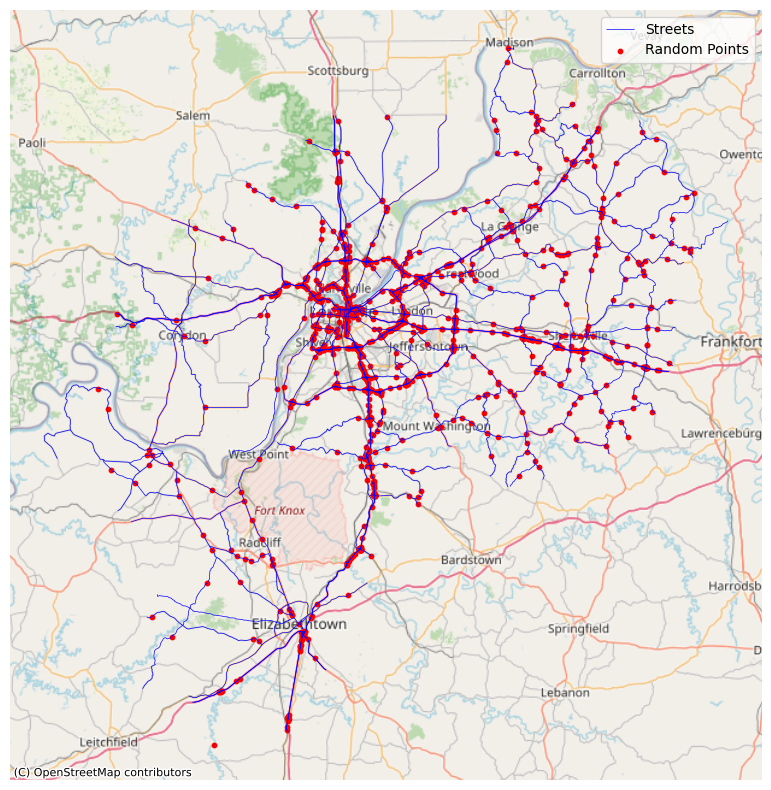

In [22]:
# Plot the streets and points
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, linewidth=0.5, color='blue', label='Streets')
points_gdf.plot(ax=ax, color='red', markersize=10, label='Random Points')

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend and axis off
ax.legend()
ax.set_axis_off()

# Show the plot
plt.show()

In [12]:
# Print coordinates of the points
for idx, point in enumerate(points_gdf.geometry):
    if isinstance(point, Point):
        print(f"Point {idx + 1}: ({point.x}, {point.y})")

Point 1: (-9497656.822748596, 4662714.599580686)
Point 2: (-9497199.371926792, 4663305.658164149)
Point 3: (-9497485.90167698, 4663582.219833586)
Point 4: (-9497440.889613245, 4648500.511065626)
Point 5: (-9521234.336809997, 4626777.763472814)
Point 6: (-9492574.127337143, 4630003.88067129)
Point 7: (-9491507.083670145, 4629898.053722348)
Point 8: (-9510588.166315379, 4594098.202012013)
Point 9: (-9510467.75196122, 4594557.017718468)
Point 10: (-9520402.998143412, 4587686.468728829)
Point 11: (-9518218.031682765, 4588275.251522447)
Point 12: (-9523302.565387111, 4589663.198685853)
Point 13: (-9540057.473916056, 4579066.408937919)
Point 14: (-9478954.394103624, 4587434.777270652)
Point 15: (-9483670.51054498, 4656212.873933197)
Point 16: (-9483481.43759609, 4654567.9157335255)
Point 17: (-9506211.775610749, 4676992.070347955)
Point 18: (-9507945.8633687, 4663139.948696253)
Point 19: (-9506863.470539311, 4658615.201326142)
Point 20: (-9507597.121220954, 4661706.373083193)
Point 21: (-950

In [23]:
# Parameters
num_generations = 100  # Number of generations
population_size = 50  # Number of individuals in the population
mutation_rate = 0.1  # Probability of mutation
max_radius = 2000  # Max radius (meters)
base_cost = 10000  # Base cost per station

In [24]:
# Create initial population
def create_individual():
    return [(random.choice(all_points), random.uniform(500, max_radius)) for _ in range(random.randint(1, 10))]

def create_population():
    return [create_individual() for _ in range(population_size)]

In [25]:
# Fitness function
def fitness(individual, map_bounds):
    coverage = set()  # To track unique covered points
    total_cost = 0

    for point, radius in individual:
        buffer = point.buffer(radius)
        total_cost += base_cost + radius * 2  # Cost increases with radius
        for x in np.arange(map_bounds[0], map_bounds[2], 100):  # Sampling grid
            for y in np.arange(map_bounds[1], map_bounds[3], 100):
                sample_point = Point(x, y)
                if buffer.contains(sample_point):
                    coverage.add((x, y))
    
    coverage_score = len(coverage)  # Unique points covered
    if total_cost > 500000:  # Penalize high costs
        return -float('inf')
    return coverage_score - (total_cost / 1000)  # Balance between coverage and cost

In [26]:
# Crossover
def crossover(parent1, parent2):
    split = random.randint(0, min(len(parent1), len(parent2)))
    child1 = parent1[:split] + parent2[split:]
    child2 = parent2[:split] + parent1[split:]
    return child1, child2

In [27]:
# Mutation
def mutate(individual):
    if random.random() < mutation_rate:
        if random.random() > 0.5 and len(individual) > 1:
            # Remove a random point
            individual.pop(random.randint(0, len(individual) - 1))
        else:
            # Add a new random point
            individual.append((random.choice(all_points), random.uniform(500, max_radius)))
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            # Change radius of a random point
            individual[i] = (individual[i][0], random.uniform(500, max_radius))
    return individual

In [30]:
# Genetic Algorithm
def genetic_algorithm():
    population = create_population()
    map_bounds = streets.total_bounds  # Bounds of the map
    print('starting')
    
    for generation in range(num_generations):
        # Evaluate fitness
        population = sorted(population, key=lambda ind: fitness(ind, map_bounds), reverse=True)
        best_individual = population[0]
        print(f"Generation {generation}: Best Fitness = {fitness(best_individual, map_bounds)}")
        
        # Create the next generation
        new_population = population[:10]  # Elitism
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(population[:20], k=2)  # Select from top individuals
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1), mutate(child2)])
        
        population = new_population[:population_size]

    return best_individual

In [ ]:
# Run the genetic algorithm
best_solution = genetic_algorithm()

starting


In [ ]:
# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, linewidth=0.5, color='blue', label='Streets')

# Draw the charging station areas
for point, radius in best_solution:
    buffer = point.buffer(radius)
    ax.plot(point.x, point.y, 'ro')  # Plot the center
    gpd.GeoSeries([buffer]).plot(ax=ax, alpha=0.3, color='green')  # Plot the radius

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.legend(['Streets', 'EV Stations'])
plt.show()